<a href="https://colab.research.google.com/github/engineerJPark/FCN_Implementation/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

- take checker board calibration
- get distance and make extrinsic matrix

- validation IoU
- validation mAP

# model training and test

In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

In [ ]:
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

# print('--------------------------------')
# print('--------------------------------')
# print(resnet_pretrained)

print('Done.')

# torch.autograd.set_detect_anomaly(True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Turn Off the inplace operation
.
.
.
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/voc_data'

Mounted at /content/gdrive


In [ ]:
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])

    def __init__(self, root='/content/gdrive/MyDrive/voc_data', split='train', transform_tf=True):
        self.root = root
        self.split = split
        self.transform_tf = transform_tf
        self.transform = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
            transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        self.transform_lbl = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST)
        ])

        dataset_dir = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = os.path.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = os.path.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # data file
        data_file = self.files[self.split][index]
        
        # load
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = torch.from_numpy(np.array(img)).to(torch.float)

        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
        lbl = torch.unsqueeze(lbl, dim=0)

        # image preprocessing
        img = img.permute(2, 0, 1) # HWC -> CHW
        lbl[lbl == 255] = -1

        # image transform
        if self.transform_tf == True:
            return self.transform(img), self.transform_lbl(lbl)
        else:
            return img, lbl


train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)

train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

In [ ]:
# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

In [ ]:
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7) # error log occured
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

In [ ]:
epochs = 10
lr = 10e-4
weight_decay = 2e-4
momentum = 0.9
batch_size = 64

model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
# # train code
# def train(model, epochs, optimizer, criterion):
#   # with torch.autograd.detect_anomaly():
#   for epoch in range(epochs):
#     running_loss = 0
#     for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
#       train_img = train_img.to(device)
#       train_gt_img = train_gt_img.squeeze(dim=1).to(device)

#       score_img = model(train_img)
#       score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
#       train_gt_img = train_gt_img.reshape(-1, )

#       loss = criterion(score_img, train_gt_img)

#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

#       running_loss += loss
    
#     print('======================================')
#     print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

#     EPOCH = epoch
#     PATH = "/content/gdrive/MyDrive/fcn_model/model_%d" % (epoch + 1)
#     LOSS = running_loss

#     torch.save({
#                 'epoch': EPOCH,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': LOSS,
#                 }, PATH)
  
#   print("Training End")

# train(model, epochs, optimizer, criterion)

## Test

In [ ]:
test_model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_%d' % (epochs)

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.eval()
print('model evaluation start')

model evaluation start


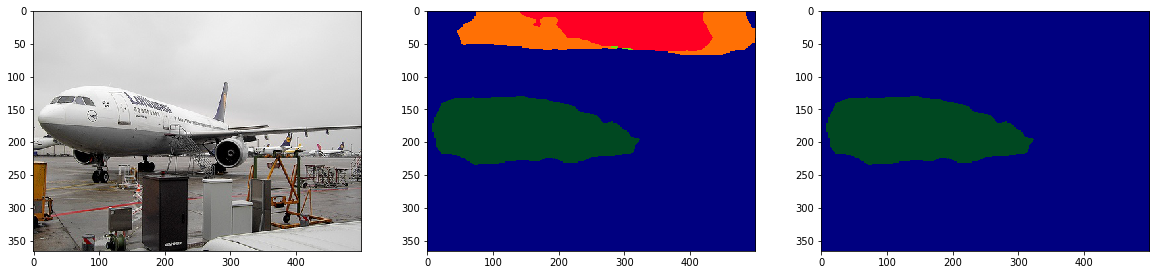

In [ ]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')
test_jpg = lines[0] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
return_transform = transforms.Compose([
    transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
])

test_seg = test_model(
    test_transform(test_image)
    )
test_seg = return_transform(test_seg)
test_seg[test_seg <= 8] = 0 # Thresholding

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

# print(test_image_channel_idx[30, 75])

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)

# model prediction for only one class
test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
finding_class = 1 # editable
test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0

# to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,3)
plt.imshow(test_image_PIL)
plt.show()

In [ ]:
# validation IoU mAP



In [ ]:
# validation mAP



In [ ]:
# x = torch.tensor([[2,3,4],
#                   [2,3,4],
#                   [2,3,4]])
# y = torch.ones((x.shape[0], x.shape[1] + 1))
# y[:, :-1] = x
# print(y)

# for i in range(len(x)):
#   # x[i] = torch.cat((x[i], torch.tensor([1])), dim=0) # need to be test
#   # x[i] = torch.cat((torch.tensor([1]), torch.tensor([1]), torch.tensor([1])), dim=0)

# print(x)

tensor([[2., 3., 4., 1.],
        [2., 3., 4., 1.],
        [2., 3., 4., 1.]])


# codes for inference in other computer



In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

import PIL
import os

import open3d.camera.PinholeCameraIntrinsic as PinholeCameraIntrinsic
import open3d.camera.PinholeCameraParameters as PinholeCameraParameters
import open3d.PointCloud as PointCloud
import open3d.Vector3dVector as Vector3dVector

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

ModuleNotFoundError: ignored

In [ ]:
# a = torch.randn(4, 4)
# print(a)
# torch.max(a, 0)[0][0]

# np.array((np.array([1]), np.array([1]), 1))

# a = np.array([1,1,1])
# b = np.array([1,1,1])
# c = np.array([1,1,1])

# np.stack((a, b, c), axis=1)

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [ ]:
# camera Calibration

class predict_coord():
  '''
  HOW TO USE ???
  1. initialize with model
  2. take camera calibration
  3. get_cp_and_gw_on_point_cloud
  '''

  def __init__(self, model):
    self.model = model

  def calibrate_camera(self):
    '''
    need to be calculated
    '''

    # intrinsic
    width, height, fx, fy, cx, cy = 0., 0., 0., 0., 0., 0.

    # extrinsic. should be orthonormal
    rx1, rx2, rx3 = 0., 0., 0. # unit vector from robot frame (world coordinate)
    ry1, ry2, ry3 = 0., 0., 0.
    rz1, rz2, rz3 = 0., 0., 0.
    c1, c2, c3 = 0., 0., 0. # robot to camera distance
    
    t1 = -1 * (rx1 * c1 + rx2 * c2 + rx3 * c3)
    t2 = -1 * (ry1 * c1 + ry2 * c2 + ry3 * c3)
    t3 = -1 * (rz1 * c1 + rz2 * c2 + rz3 * c3)

    self.cam_intrinsic = PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    self.cam_intrinsic.intrinsic_matrix = np.array([[fx, 0, cx], 
                                                    [0, fy, cy], 
                                                    [0, 0, 1]])

    self.cam = PinholeCameraParameters()
    self.cam.intrinsic = self.cam_intrinsic
    self.cam.extrinsic = np.array([[rx1, rx2, rx3, t1], 
                                   [ry1, ry2, ry3, t2], 
                                   [rz1, rz2, rz3, t3], 
                                   [0., 0., 0., 1.]])
    
    self.cam_extrinsic_mat_inverse = np.linalg.inv(self.cam.extrinsic)
    self.cam_projection_mat = np.matmul(self.cam.intrinsic.intrinsic_matrix, self.cam.extrinsic) # ~u = P  x_world
    self.cam_projection_mat_inverse = np.linalg.inv(self.cam_projection_mat)

    # pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, cam.intrinsic, cam.extrinsic)

  def img_to_world(self, img_xyz, s_depth : float):
    '''
    네가 쓸 것 아니다
    transform pixel image data to world coordinate
    xyz = [u v 1]
    s_depth = scaling factor, depth from camera to image
    s_depth * [u v 1] = self.cam_projection_mat * [xw yw zw 1]
    '''
    world_xyz = s_depth * np.matmul(self.cam_projection_mat_inverse, img_xyz)
    return world_xyz # numpy


  def camera_to_world(self, cam_xyz):
    '''
    네가 쓸 것 아니다
    transform camera image data to world coordinate
    '''
    world_xyz = np.matmul(self.cam_extrinsic_mat_inverse, cam_xyz)
    return world_xyz # numpy


  def image_xyz_to_open3d(self, xyz, s_depth=1., ref='image'):
      '''
      네가 쓸 것 아니다
      xyz : numpy array of xyz tuples/lists : N of points X xyz Dimension
      '''
      if ref == 'image':
        for i in range(len(xyz)):
          xyz[i] = self.img_to_world(xyz[i], s_depth)
      elif ref == 'cam':
        for i in range(len(xyz)):
          xyz[i] = self.camera_to_world(xyz[i])
      else:
        pass

      # Check empty
      open3d_cloud = PointCloud()
      if len(xyz) == 0:
          print("Converting an empty cloud")
          return None

      open3d_cloud.points = Vector3dVector(xyz)
      return open3d_cloud # open3d


  def get_cp_and_gw_on_point_cloud(self, pixel_img : PIL.Image, finding_class, s_depth=1.): 
    '''
    네가 쓸 것 맞다
    get center point of object(CP) and grasping width(GW) by fcn model
    안되면 point cloud로 전체 pixel을 옮겨서 cp와 width를 표시
    '''
    # test image transform & input to test model
    pixel_img = np.array(pixel_img)
    pixel_img = torch.from_numpy(pixel_img).to(torch.float).permute(2,0,1)
    ori_x, ori_y = pixel_img.shape[1], pixel_img.shape[2]

    pixel_img = torch.unsqueeze(pixel_img, dim=0)

    test_transform = transforms.Compose([
        transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
        transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return_transform = transforms.Compose([
        transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
    ])

    # model prediction
    test_seg = self.model(
        test_transform(pixel_img)
        )
    test_seg = return_transform(test_seg)
    test_seg[test_seg <= 8] = 0 # Thresholding
    test_seg_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

    # point cloud calculation
    test_seg_idx_yx = (test_seg_idx == finding_class).nonzero(as_tuple=False)
    test_seg_idx_yx_aug = torch.ones((test_seg_idx_yx.shape[0], test_seg_idx_yx.shape[1] + 1))
    test_seg_idx_yx_aug[:, :-1] = test_seg_idx_yx
    test_seg_idx_yx_aug = test_seg_idx_yx_aug.numpy()

    seg2point_cloud = self.image_xyz_to_open3d(test_seg_idx_yx_aug, s_depth=s_depth, ref='image') # need to be return, open3d PointCloud

    for i in range(len(test_seg_idx_yx_aug)):
      test_seg_idx_yx_aug[i] = self.img_to_world(test_seg_idx_yx_aug[i], s_depth)

    test_max_x = np.max(test_seg_idx_yx_aug, axis=0)[1] # np.int
    test_min_x = np.min(test_seg_idx_yx_aug, axis=0)[1]
    test_max_y = np.max(test_seg_idx_yx_aug, axis=0)[0]
    test_min_y = np.min(test_seg_idx_yx_aug, axis=0)[0]

    # image plane coordinates (not normal)
    cp = np.array(((test_max_y + test_min_y) / 2, (test_max_x + test_min_x) / 2, 1))
    width = test_max_x - test_min_x
    left_side = np.array((cp[0] - width / 2, cp[1], 1))
    right_side = np.array((cp[0] + width / 2, cp[1], 1))

    cp_and_side_point_cloud = PointCloud()
    cp_and_side_point_cloud.points = Vector3dVector(np.stack((cp, left_side, right_side), axis=1)) # dimension 확인할 것

    return seg2point_cloud, cp_and_side_point_cloud

In [ ]:
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7) # error log occured
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

test_model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_%d' % (epochs)

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.eval()
print('model evaluation start')

In [ ]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')
test_jpg = lines[0] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg))

plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(test_image)

test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
return_transform = transforms.Compose([
    transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
])

test_seg = test_model(
    test_transform(test_image)
    )
test_seg = return_transform(test_seg)
test_seg[test_seg <= 8] = 0 # Thresholding

test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

# print(test_image_channel_idx[30, 75])

test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

plt.subplot(1,2,2)
plt.imshow(test_image_PIL)
plt.show()

# Reference

# mAP and IoU implementation

- https://discuss.pytorch.org/t/iou-pytorch-implementation/21473
- https://pytorch.org/vision/stable/ops.html
- https://stackoverflow.com/questions/48260415/pytorch-how-to-compute-iou-jaccard-index-for-semantic-segmentation
- https://github.com/Cartucho/mAP
- https://github.com/sunnynevarekar/pytorch-saliency-maps



# camera calibration

- http://www.open3d.org/docs/release/python_api/open3d.camera.PinholeCameraIntrinsic.html

- https://velog.io/@openjr/ROS-Camera-Calibration

- https://pinkwink.kr/1353

- https://learnopencv.com/camera-calibration-using-opencv/

- https://darkpgmr.tistory.com/84
- https://darkpgmr.tistory.com/83
- https://darkpgmr.tistory.com/81
- https://darkpgmr.tistory.com/82
- https://darkpgmr.tistory.com/122?category=460965
- https://darkpgmr.tistory.com/32
- https://darkpgmr.tistory.com/122
- https://fpcv.cs.columbia.edu/

- https://pcl.gitbook.io/tutorial/
- https://github.com/felixchenfy/open3d_ros_pointcloud_conversion

segmentation을 open3d로 보내준 뒤, open3d로 변환한 point cloud를 잘라준다.